# Compute SNR for galactic binaries

### Imports and constants

In [1]:
from gbgpu import gbgpu
import pandas as pd
import numpy as np

# useful imports
from lisatools.sensitivity import LISASens, get_sensitivity, get_stock_sensitivity_options
from lisatools.sensitivity import SensitivityMatrix, LISASens, A1TDISens, E1TDISens
import lisatools.detector as lisa_models
import matplotlib.pyplot as plt

from lisatools.utils.constants import YRSID_SI
from tqdm import tqdm
import glob

from lisatools.sensitivity import *

YEAR = 525600 * 60

In [5]:
df = pd.read_feather('../data/sangria_ucb_params.feather')

In [6]:
df

,Name,Amplitude,Ecliptic Latitude,Ecliptic Longitude,Frequency,Frequency Derivative,Inclination,Initial Phase,Polarization,SNR,Detached
0,7485992.0,2.671490e-24,-0.042565,4.674532,0.000175,1.358732e-21,0.839587,2.771795,3.673366,0.005477,1
1,5631975.0,2.238406e-24,-1.018681,2.939293,0.000094,1.080583e-22,1.951635,1.635223,5.707671,0.001142,1
2,10315260.0,2.460404e-24,-0.703462,4.164216,0.000176,1.867842e-21,1.131026,3.290443,1.195415,0.003566,1
3,11618907.0,3.886525e-24,0.030302,4.566779,0.000112,1.809940e-22,1.917469,6.096522,1.006040,0.002761,1
4,13651699.0,2.271599e-24,0.011172,4.611218,0.000096,1.780151e-22,1.609004,0.329538,4.642059,0.000936,1
...,...,...,...,...,...,...,...,...,...,...,...
28999995,2999995.0,5.493277e-25,-0.105611,4.671226,0.000634,-2.539879e-21,2.292614,3.765058,2.293617,0.011023,0
28999996,2999996.0,2.210062e-25,-0.068321,4.690494,0.000559,-9.684470e-22,1.586806,4.270285,4.130861,0.001642,0
28999997,2999997.0,2.713618e-25,0.096602,4.741024,0.000597,-1.265121e-21,2.585573,2.304033,6.212203,0.005604,0
28999998,2999998.0,3.090526e-25,0.118990,4.798757,0.000710,-4.418585e-21,0.138954,1.705343,4.937407,0.013784,0


In [3]:
def make_get_snr():
    gb = gbgpu.GBGPU()
    time = np.arange(0, YRSID_SI, 5.0)
    f = np.fft.rfftfreq(len(time), d=5.0)[1:]
    data = [np.zeros(len(f)), np.zeros(len(f))]
    sens_mat3 = AE1SensitivityMatrix(
        f,
        stochastic_params=(1.0 * YRSID_SI,),
        model=lisa_models.sangria,
    )
    def get_snr(params_dict):
        # name = params_dict['Name']
        amp = params_dict['Amplitude']
        f0 = params_dict['Frequency']
        fdot = params_dict['Frequency Derivative']
        fddot = 0.0
        phi0 = params_dict['Initial Phase']
        iota = params_dict['Inclination']
        psi = params_dict['Polarization']
        lam = params_dict['Ecliptic Longitude']
        beta = params_dict['Ecliptic Latitude']

        params = np.array([amp, f0, fdot, fddot, phi0, iota, psi, lam, beta])
        params.reshape((1, -1))
        gb.d_d = 0.0
        gb.get_ll(params, data, sens_mat3)[0]
        return np.sqrt(np.real(gb.h_h))
    return get_snr

In [4]:
get_snr = make_get_snr()

In [5]:
names = []
snr_values = []
start_index = 0
for i in tqdm(range(start_index, len(df))):
    params_dict = df.iloc[i].to_dict()
    name = params_dict['Name']
    snr = get_snr(params_dict)
    names.append(name)
    snr_values.append(snr)
    if len(snr_values) % 10_000 == 0:
        np.savetxt(f'./snrs/snr_values_{i // 10_000}.txt', np.c_[names, snr_values])
        names = []
        snr_values = []

100%|██████████| 29000000/29000000 [3:11:37<00:00, 2522.33it/s]  


In [7]:
names = []
snrs = []
for i in range(2900):
    name, snr = np.loadtxt(f'/Users/aaron/Documents/lisa/project-catalog/old_files/snrs/snr_values_{i}.txt', unpack=True)
    names.append(name)
    snrs.append(snr)


In [9]:
names = np.hstack(names)
snrs = np.hstack(snrs)

In [12]:
df['SNR'] = snrs

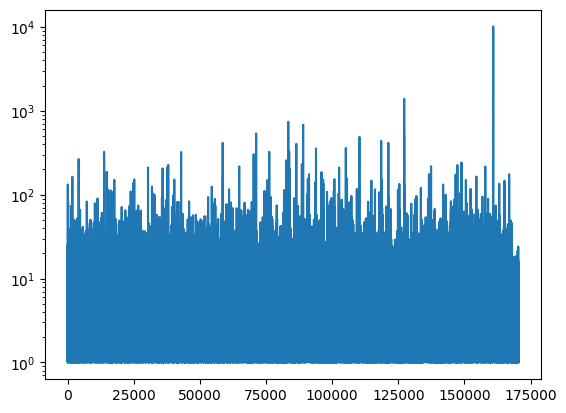

In [20]:
plt.semilogy(snrs[snrs > 1])